In [132]:
from sqlalchemy import create_engine
from rent_scrapper import Arkadia_scrapper,push_newest_data
import pandas as pd
import matplotlib.pyplot as plt

In [133]:
#push_newest_data()

In [134]:
config = { 'user': "root",
            'password': "rootroot",
            'host': "localhost",
            'database': "apartments",
            'port': '3306'}

In [135]:
def create_url(user, password, host, database, port):
    return f"mysql://{user}:{password}@{host}:{port}/{database}"

pool = create_engine(url=create_url(**config),
                     pool_size=20, max_overflow=0
                     )
with pool.connect() as conn:
    sql = """SELECT m.room_number ,
m.apartment ,
date_update ,
price_floor ,
price_ceil ,
Avaliable_date ,
`Sq.Ft` ,
Floor_Plan ,
num_bedroom ,
num_bathroom
FROM apartments.prices p
	LEFT JOIN apartments.room_meta m
		ON p.apartment = m.apartment AND p.room_number = m.room_number;"""
    df = pd.read_sql(sql, conn)

In [136]:
df = df.merge(df.groupby(['Sq.Ft','date_update']).price_floor.mean().reset_index().rename({'price_floor':'price_mean_horizontal'},axis=1),
         on = ['Sq.Ft','date_update'])
df = df.merge( df.groupby('room_number').price_floor.mean().reset_index().rename({'price_floor':'price_mean_vertical'},axis=1),
               on = 'room_number')

In [137]:
df['deviation_from_cohort'] = df.eval('price_floor - price_mean_horizontal')
df['deviation_from_history'] = df.eval('price_floor - price_mean_vertical')
df['price_sqft'] = df.eval('price_floor / `Sq.Ft`')

In [138]:
# Analyze best deals
df.dropna(subset='price_floor').query('price_floor < price_mean_horizontal').sort_values(['room_number','date_update','price_mean_horizontal'])

,room_number,apartment,date_update,price_floor,price_ceil,Avaliable_date,Sq.Ft,Floor_Plan,num_bedroom,num_bathroom,price_mean_horizontal,price_mean_vertical,deviation_from_cohort,deviation_from_history,price_sqft
1300,#0701,Arkadia,2022-11-02,3740.0,4380.0,None,1168.0,2 Bed/2 Bath-01,2,2,3833.5,3739.019231,-93.5,0.980769,3.202055
1301,#0701,Arkadia,2022-11-03 12:52:26,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.5,3739.019231,-93.5,-0.019231,3.201199
1302,#0701,Arkadia,2022-11-03 13:00:27,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.5,3739.019231,-93.5,-0.019231,3.201199
1303,#0701,Arkadia,2022-11-03 13:40:33,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.5,3739.019231,-93.5,-0.019231,3.201199
1304,#0701,Arkadia,2022-11-03 14:00:27,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.5,3739.019231,-93.5,-0.019231,3.201199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,#2902,Arkadia,2022-11-05 09:00:26,2497.0,2832.0,None,700.0,1 Bed/1 Bath-02,1,1,2512.0,2620.365385,-15.0,-123.365385,3.567143
464,#2902,Arkadia,2022-11-05 10:00:25,2497.0,2832.0,None,700.0,1 Bed/1 Bath-02,1,1,2512.0,2620.365385,-15.0,-123.365385,3.567143
465,#2902,Arkadia,2022-11-05 11:00:29,2497.0,2832.0,None,700.0,1 Bed/1 Bath-02,1,1,2512.0,2620.365385,-15.0,-123.365385,3.567143
466,#2902,Arkadia,2022-11-05 11:24:55,2497.0,2832.0,None,700.0,1 Bed/1 Bath-02,1,1,2512.0,2620.365385,-15.0,-123.365385,3.567143


In [139]:
# Analyze best deals
df.dropna(subset='price_floor').query('price_floor < price_mean_vertical').sort_values(['room_number','date_update','deviation_from_history'])

,room_number,apartment,date_update,price_floor,price_ceil,Avaliable_date,Sq.Ft,Floor_Plan,num_bedroom,num_bathroom,price_mean_horizontal,price_mean_vertical,deviation_from_cohort,deviation_from_history,price_sqft
1301,#0701,Arkadia,2022-11-03 12:52:26,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.500000,3739.019231,-93.500000,-0.019231,3.201199
1302,#0701,Arkadia,2022-11-03 13:00:27,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.500000,3739.019231,-93.500000,-0.019231,3.201199
1303,#0701,Arkadia,2022-11-03 13:40:33,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.500000,3739.019231,-93.500000,-0.019231,3.201199
1304,#0701,Arkadia,2022-11-03 14:00:27,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.500000,3739.019231,-93.500000,-0.019231,3.201199
1305,#0701,Arkadia,2022-11-03 15:00:27,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.500000,3739.019231,-93.500000,-0.019231,3.201199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,#3212,Arkadia,2022-11-05 09:00:26,2547.0,3019.0,1/7/2023,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2582.769231,107.833333,-35.769231,3.187735
1088,#3212,Arkadia,2022-11-05 10:00:25,2547.0,3019.0,1/7/2023,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2582.769231,107.833333,-35.769231,3.187735
1089,#3212,Arkadia,2022-11-05 11:00:29,2547.0,3019.0,1/7/2023,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2582.769231,107.833333,-35.769231,3.187735
1090,#3212,Arkadia,2022-11-05 11:24:55,2547.0,3019.0,1/7/2023,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2582.769231,107.833333,-35.769231,3.187735


<AxesSubplot:>

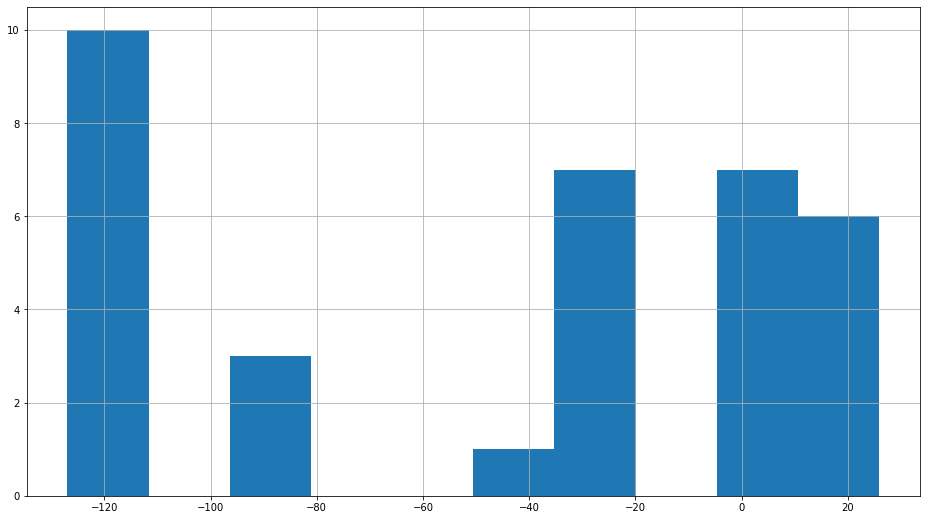

In [140]:
# Understand trend
df.query('date_update == "{}"'.format(df.date_update.max())).deviation_from_history.hist(figsize=(16,9))

In [141]:
def show_history(df_floor_group,title,by='price_floor'):
    legends = []
    plt.figure(figsize=(20,10))
    for group,df_group in df_floor_group.groupby('room_number'):
        legends.append(group+'|'+str(df_group['Sq.Ft'].to_list()[-1]))
        df_group = df_group.set_index('date_update')
        plt.plot(df_group.index, df_group[by])
    for group,df_group in df_floor_group.groupby('room_number'):
        #legends.append(group+'|'+str(df_group['Sq.Ft'].to_list()[-1]))
        df_group = df_group.set_index('date_update')
        plt.scatter(df_group.index, df_group[by])
    plt.legend(legends,loc='lower left', bbox_to_anchor=(1.01, 0., 0.5, 0.5))
    plt.title(title)
    plt.show()

In [142]:
df.query('date_update == "{}"'.format(df.date_update.max())).sort_values('price_sqft')

,room_number,apartment,date_update,price_floor,price_ceil,Avaliable_date,Sq.Ft,Floor_Plan,num_bedroom,num_bathroom,price_mean_horizontal,price_mean_vertical,deviation_from_cohort,deviation_from_history,price_sqft
1039,#2212,Arkadia,2022-11-05 11:36:44,2332.0,2745.0,12/20/2022,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2364.615385,-107.166667,-32.615385,2.918648
1727,#1812,Arkadia,2022-11-05 11:36:44,2335.0,2661.0,11/11/2022,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2335.000000,-104.166667,0.000000,2.922403
1247,#2113,Arkadia,2022-11-05 11:36:44,2505.0,2914.0,12/11/2022,847.0,1 Bed/1 Bath-13,1,1,2576.666667,2537.596154,-71.666667,-32.596154,2.957497
935,#1712,Arkadia,2022-11-05 11:36:44,2402.0,2731.0,11/6/2022,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2435.500000,-37.166667,-33.500000,3.006258
1143,#2313,Arkadia,2022-11-05 11:36:44,2592.0,2932.0,None,847.0,1 Bed/1 Bath-13,1,1,2576.666667,2625.500000,15.333333,-33.500000,3.060213
1195,#2713,Arkadia,2022-11-05 11:36:44,2633.0,2980.0,11/21/2022,847.0,1 Bed/1 Bath-13,1,1,2576.666667,2666.500000,56.333333,-33.500000,3.108619
987,#2612,Arkadia,2022-11-05 11:36:44,2494.0,2831.0,12/1/2022,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2527.519231,54.833333,-33.519231,3.121402
883,#2912,Arkadia,2022-11-05 11:36:44,2525.0,2860.0,None,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2558.519231,85.833333,-33.519231,3.160200
1091,#3212,Arkadia,2022-11-05 11:36:44,2547.0,3019.0,1/7/2023,799.0,1 Bed/1 Bath-12,1,1,2439.166667,2582.769231,107.833333,-35.769231,3.187735
1351,#0701,Arkadia,2022-11-05 11:36:44,3739.0,4379.0,None,1168.0,2 Bed/2 Bath-01,2,2,3832.500000,3739.019231,-93.500000,-0.019231,3.201199


In [143]:
df_meta = df.query('date_update == "{}"'.format(df.date_update.max()))[['room_number','apartment','Avaliable_date','Sq.Ft','Floor_Plan','num_bedroom','num_bathroom']]

In [144]:
pool = create_engine(url=create_url(**config),
                     pool_size=20, max_overflow=0,
                     )
with pool.connect() as conn:
    df_meta.to_sql('room_meta', conn, if_exists='append',index=False)

C:\Users\18066\AppData\Local\Temp/ipykernel_13920/966882147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.date_update = pd.DatetimeIndex(df_plot.date_update)


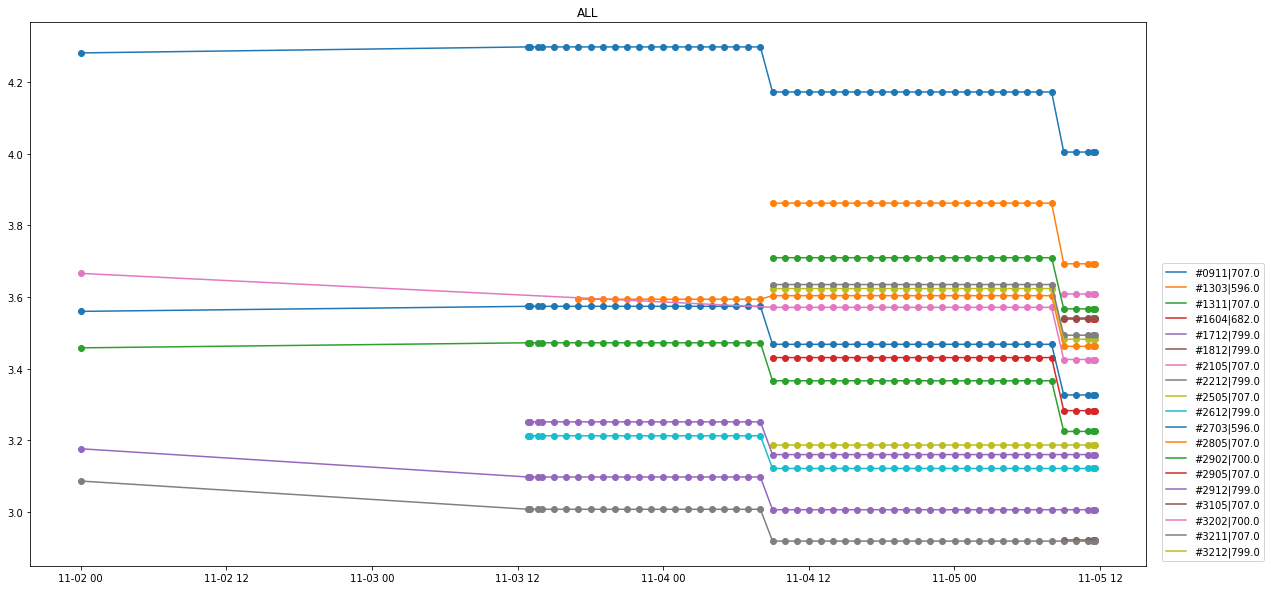

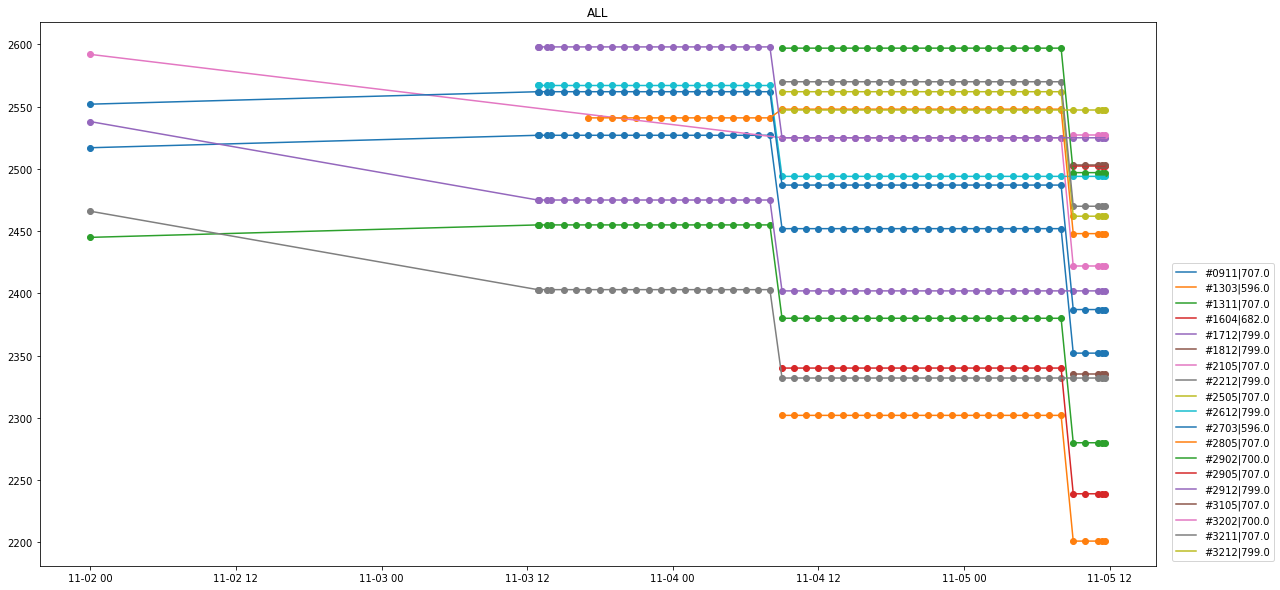

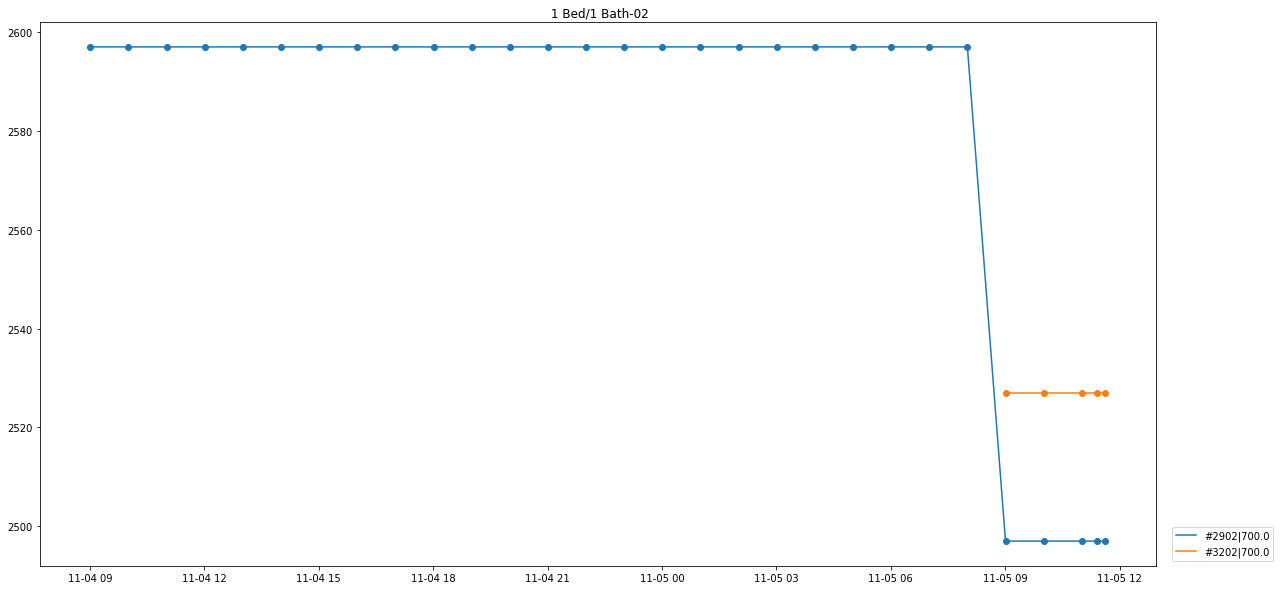

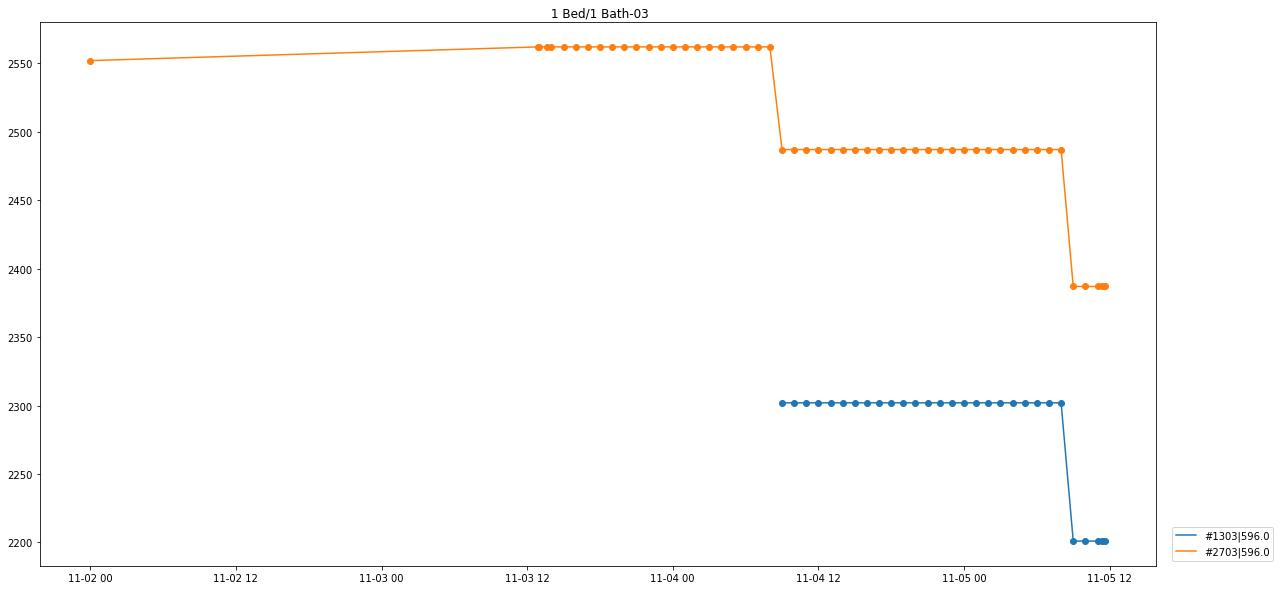

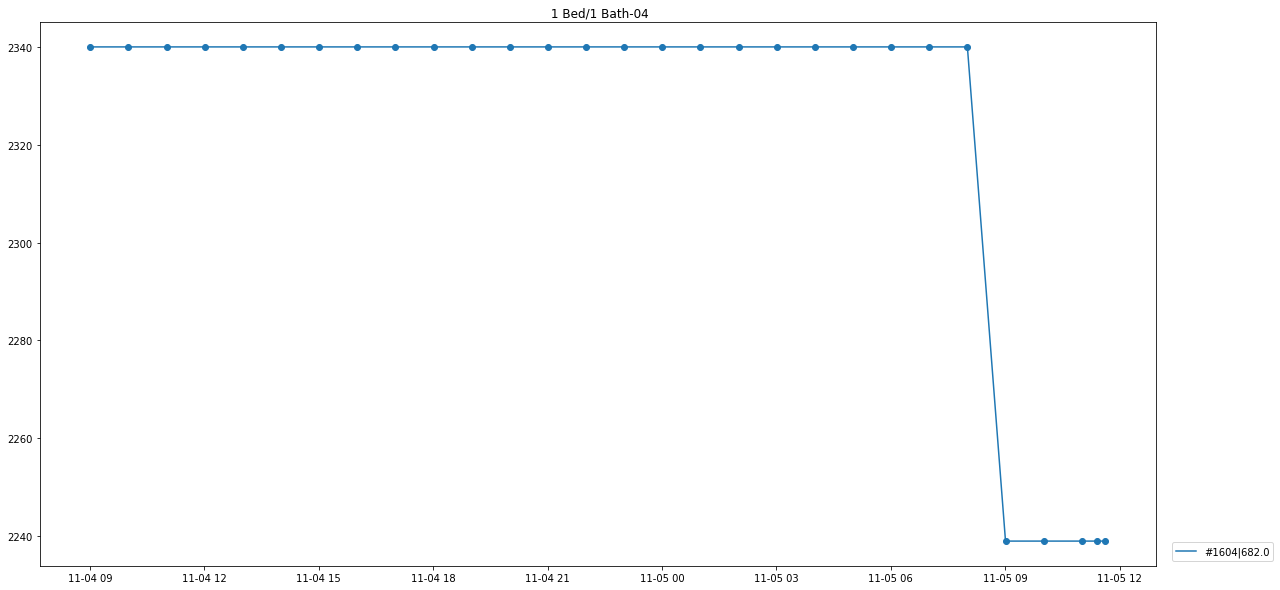

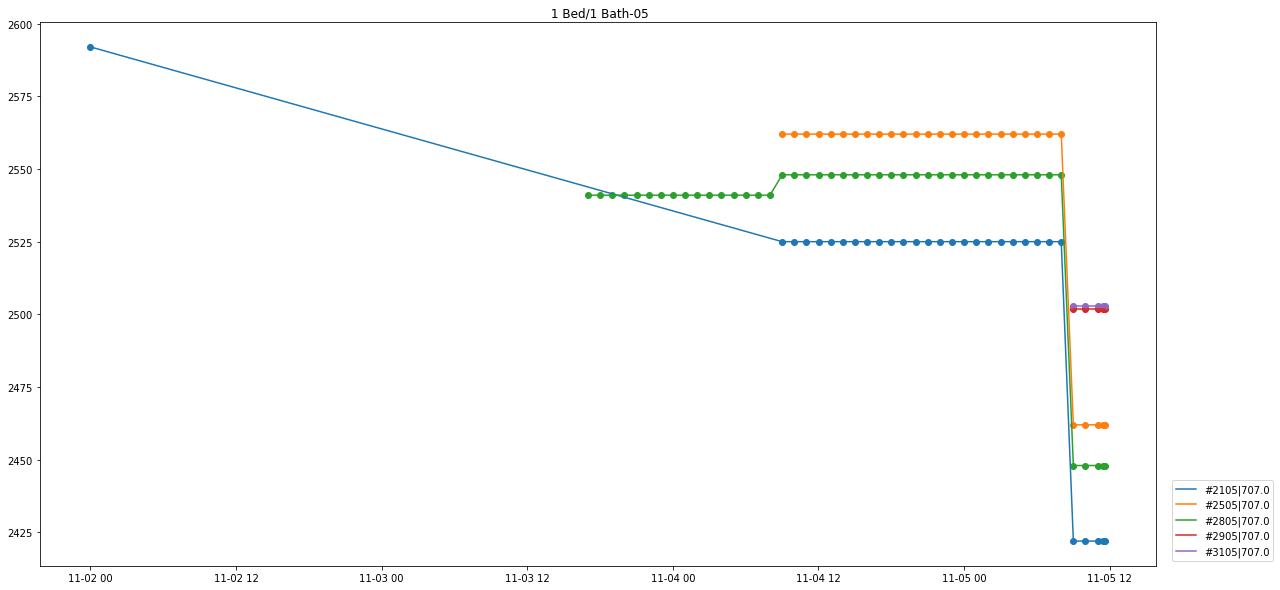

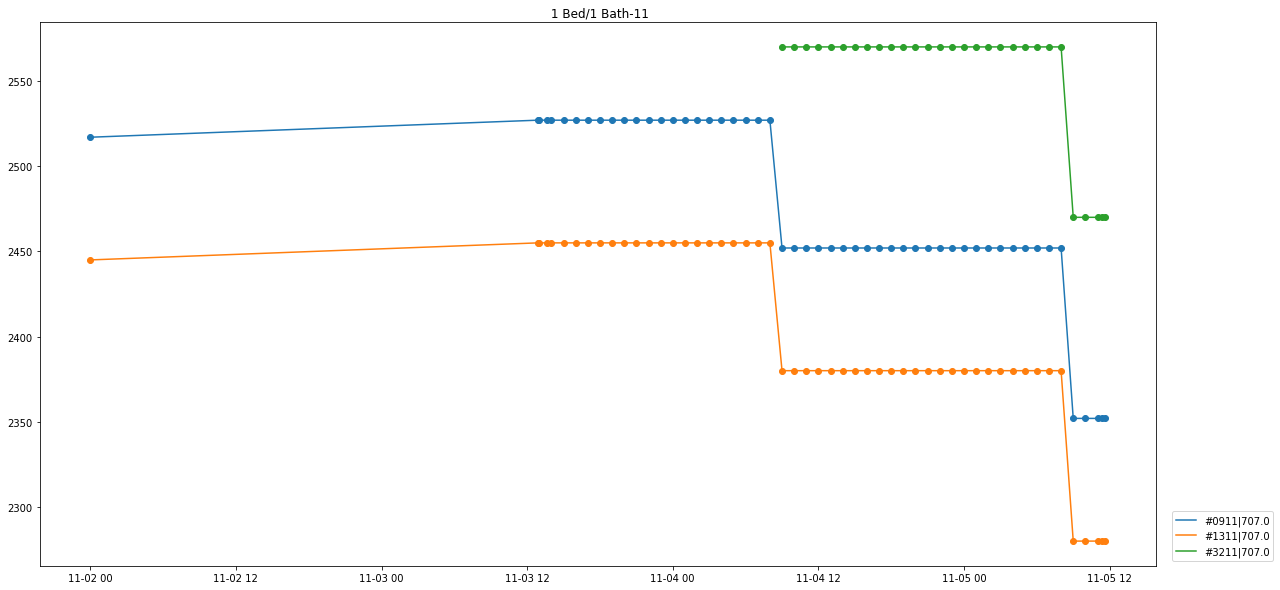

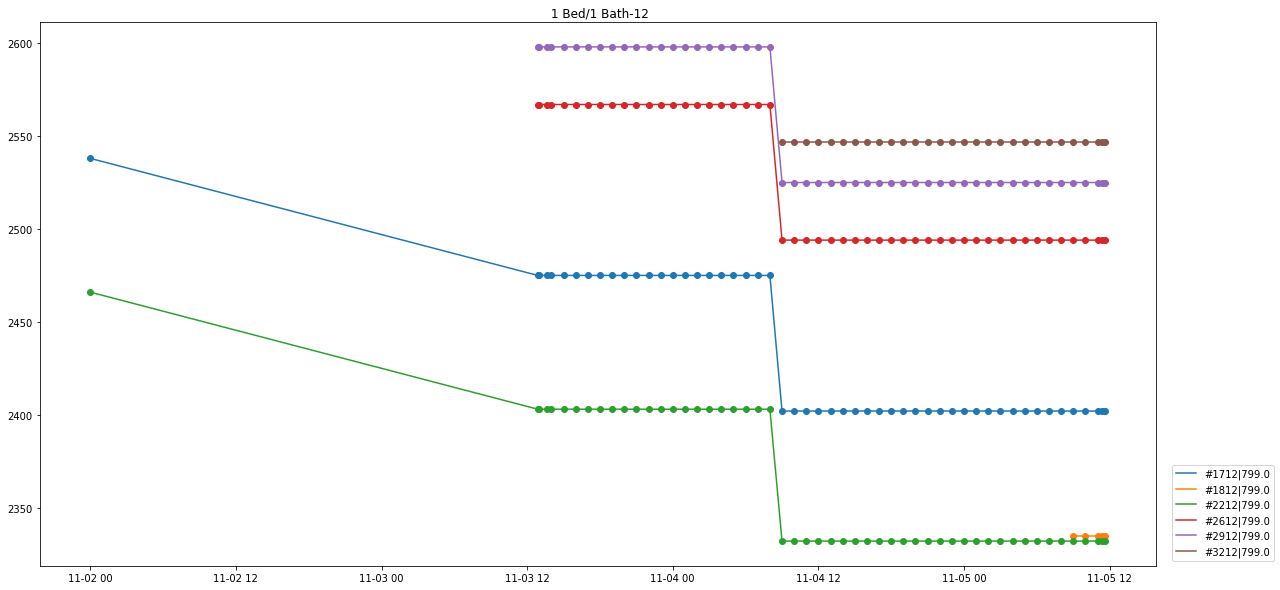

In [145]:
df_plot = df.query('num_bedroom == "1" and num_bathroom == "1" and price_floor < 2600 and `Sq.Ft` <'
                   '= 799')#.sort_values('price_floor',ascending=False)
###
df_plot.date_update = pd.DatetimeIndex(df_plot.date_update)
show_history(df_plot,'ALL','price_sqft')
show_history(df_plot,'ALL')
for Floor_Plan,df_floor_group in df_plot.groupby('Floor_Plan'):
    show_history(df_floor_group,Floor_Plan)